In [1]:
%matplotlib inline

In [2]:
#
# We need a regression model for predicting methylation (highest priority): 
# Variables are: 
#   - Number of unique CpGs per cell
#   - Median Average Read CpG per cell (or mean if normally distributed)
#   - BS rate per cell
#   - CLL or Normal status per cell
# What is the coefficient and the P value for each variable for a model predicting methylation?

In [3]:
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
pd.set_option('display.max_columns', 50) # print all rows


import os
os.chdir('/Users/evanbiederstedt/Downloads/RRBS_data_files')

In [4]:
normal_cellA_df = pd.read_csv("unweighted_PDR_methyl_RRBS_normal_B.csv")
normal_cellB_df = pd.read_csv("unweighted_PDR_methyl_CD27pcell.csv") 
normal_cellC_df = pd.read_csv("unweighted_PDR_methyl_CD27mcell.csv")
cll_cellA_df = pd.read_csv("unweighted_PDR_methyl_RRBS_cw154.csv")
cll_cellC_df = pd.read_csv("unweighted_PDR_methyl_RRBS_trito_pool.csv")

In [5]:
print(normal_cellA_df.shape)
print(normal_cellB_df.shape) 
print(normal_cellC_df.shape)
print(cll_cellA_df.shape)
print(cll_cellC_df.shape)

print(normal_cellA_df.head())
print(normal_cellB_df.head())
normal_cellC_df.head()
cll_cellA_df.head()
cll_cellC_df.head()

(126, 5)
(90, 5)
(88, 5)
(66, 5)
(44, 5)
   Unnamed: 0                                           filename  \
0           0  RRBS_normal_B_cell_A1_24_TAAGGCGA.ACAACC.dan.a...   
1           1  RRBS_normal_B_cell_A1_24_TAAGGCGA.ACCGCG.dan.a...   
2           2  RRBS_normal_B_cell_A1_24_TAAGGCGA.ACGTGG.dan.a...   
3           3  RRBS_normal_B_cell_A1_24_TAAGGCGA.ACTCAC.dan.a...   
4           4  RRBS_normal_B_cell_A1_24_TAAGGCGA.AGGATG.dan.a...   

   PDR_unweighted  methylation_unweighted  total_reads  
0        0.254835                0.691996   11894660.0  
1        0.390562                0.620106    3744659.0  
2        0.266418                0.699736   10461874.0  
3        0.265385                0.763173      14051.0  
4        0.240201                0.732036   21928743.0  
   Unnamed: 0                                           filename  \
0           0  RRBS_NormalBCD19pCD27pcell1_22_TAGGCATG.ACAACC...   
1           1  RRBS_NormalBCD19pCD27pcell1_22_TAGGCATG.ACCGCG...   
2   

,Unnamed: 0,filename,PDR_unweighted,methylation_unweighted,total_reads
0,0,RRBS_trito_pool_1_TAAGGCGA.ACAACC.dan.annoRRBS...,0.357578,0.648881,21089805.0
1,1,RRBS_trito_pool_1_TAAGGCGA.ACGTGG.dan.annoRRBS...,0.358350,0.642320,12424887.0
2,2,RRBS_trito_pool_1_TAAGGCGA.ACTCAC.dan.annoRRBS...,0.353506,0.649909,18443935.0
3,3,RRBS_trito_pool_1_TAAGGCGA.ATAGCG.dan.annoRRBS...,0.357433,0.635992,12731278.0
4,4,RRBS_trito_pool_1_TAAGGCGA.ATCGAC.dan.annoRRBS...,0.359219,0.647797,20736297.0


In [6]:
normal_cellA_df = normal_cellA_df.drop(["Unnamed: 0"], axis=1)  
normal_cellA_df["type"] = str('normal')
normal_cellA_df["bio"] = str('normal_B')
normal_cellA_df["protocol"] = normal_cellA_df["filename"].str[5:24]
normal_cellA_df["filename"] = normal_cellA_df["filename"].str[:40]

In [7]:
normal_cellA_df.head()

,filename,PDR_unweighted,methylation_unweighted,total_reads,type,bio,protocol
0,RRBS_normal_B_cell_A1_24_TAAGGCGA.ACAACC,0.254835,0.691996,11894660.0,normal,normal_B,normal_B_cell_A1_24
1,RRBS_normal_B_cell_A1_24_TAAGGCGA.ACCGCG,0.390562,0.620106,3744659.0,normal,normal_B,normal_B_cell_A1_24
2,RRBS_normal_B_cell_A1_24_TAAGGCGA.ACGTGG,0.266418,0.699736,10461874.0,normal,normal_B,normal_B_cell_A1_24
3,RRBS_normal_B_cell_A1_24_TAAGGCGA.ACTCAC,0.265385,0.763173,14051.0,normal,normal_B,normal_B_cell_A1_24
4,RRBS_normal_B_cell_A1_24_TAAGGCGA.AGGATG,0.240201,0.732036,21928743.0,normal,normal_B,normal_B_cell_A1_24


In [8]:
cpg1 = pd.read_csv('Meth_PDR_cell_RRBS_normal_B1_CpGs.csv')
cpg1 = cpg1.drop(["Unnamed: 0"], axis=1)  
cpg1["filename"] = cpg1["filename"].str[:40]
normal_cellA_df = pd.merge(normal_cellA_df, cpg1, how='inner')
normal_cellB_df["type"] = str('normal')
normal_cellB_df = normal_cellB_df.drop(["Unnamed: 0"], axis=1) 
normal_cellB_df["bio"] = str('CD27p')
normal_cellB_df["protocol"] = normal_cellB_df["filename"].str[5:31]
normal_cellB_df["filename"] = normal_cellB_df["filename"].str[:50]
normal_cellB_df["filename"] = normal_cellB_df["filename"].str.replace(r'.dan$', '')
normal_cellB_df["filename"] = normal_cellB_df["filename"].str.replace(r'.da$', '')
cpg2 = pd.read_csv('NormalBCD19pCD27pcell_CpGs.csv')
cpg2 = cpg2.drop(["Unnamed: 0"], axis=1)  
cpg2["filename"] = cpg2["filename"].str[:50]
cpg2["filename"] = cpg2["filename"].str.replace(r'.dan$', '')
cpg2["filename"] = cpg2["filename"].str.replace(r'.da$', '')
normal_cellB_df = pd.merge(normal_cellB_df, cpg2, how='inner')
normal_cellC_df = normal_cellC_df.drop(["Unnamed: 0"], axis=1)  
normal_cellC_df["type"] = str('normal')
normal_cellC_df["protocol"] = normal_cellC_df["filename"].str[5:31]
normal_cellC_df["bio"] = str('CD27m')
normal_cellC_df["filename"] = normal_cellC_df["filename"].str[:50]
normal_cellC_df["filename"] = normal_cellC_df["filename"].str.replace(r'.dan$', '')
normal_cellC_df["filename"] = normal_cellC_df["filename"].str.replace(r'.da$', '')
cpg3 = pd.read_csv("NormalBCD19pCD27mcell_CpGs.csv")
cpg3 = cpg3.drop(["Unnamed: 0"], axis=1)  
cpg3["filename"] = cpg3["filename"].str[:50]
cpg3["filename"] = cpg3["filename"].str.replace(r'.dan$', '')
cpg3["filename"] = cpg3["filename"].str.replace(r'.da$', '')
normal_cellC_df = pd.merge(normal_cellC_df, cpg3, how='inner')
frames3 = [normal_cellA_df, normal_cellB_df, normal_cellC_df]
normal_result = pd.concat(frames3)
print(normal_result.shape)
print(normal_result.columns)

(304, 9)
Index(['PDR_unweighted', 'avgReadCpGs_mean', 'avgReadCpGs_median', 'bio',
       'filename', 'methylation_unweighted', 'protocol', 'total_reads',
       'type'],
      dtype='object')


In [9]:
normal_result = normal_result[['filename', 'methylation_unweighted', 'total_reads', 'type', 'bio', 'protocol', 'avgReadCpGs_mean', 'avgReadCpGs_median']]

In [10]:
cll_cellA_df = cll_cellA_df.drop(["Unnamed: 0"], axis=1) 
cll_cellA_df["type"] = str('CLL')
cll_cellA_df["protocol"] = cll_cellA_df["filename"].str[5:34]
cll_cellA_df["protocol"][cll_cellA_df["protocol"] == 'cw154_CutSmart_proteinase_K_T'] = 'cw154_CutSmart_proteinase_K'
cll_cellA_df["protocol"][cll_cellA_df["protocol"] == 'cw154_Tris_protease_GR_CAGAGA'] = 'cw154_Tris_protease_GR'
cll_cellA_df["protocol"][(cll_cellA_df["protocol"] != 
        'cw154_Tris_protease_GR') & (cll_cellA_df["protocol"] != 'cw154_CutSmart_proteinase_K')] = 'cw154_Tris_protease'
cll_cellA_df["bio"] = str('CLL')
cll_cellA_df["filename"] = cll_cellA_df["filename"].str[:51]
cll_cellA_df["filename"] = cll_cellA_df["filename"].str.replace(r'.da$', '')
cll_cellA_df["filename"] = cll_cellA_df["filename"].str.replace(r'.annoRR$', '')
cll_cellA_df["filename"] = cll_cellA_df["filename"].str.replace(r'.ann$', '')
cll_cellA_df["filename"] = cll_cellA_df["filename"].str.replace(r'.dan$', '')
cpg4 = pd.read_csv('CLL_RRBS_cw154_A_CpGs.csv')
cpg4 = cpg4.drop(["Unnamed: 0"], axis=1)  
cpg4["filename"] = cpg4["filename"].str[:51]
cpg4["filename"] = cpg4["filename"].str.replace(r'.da$', '')
cpg4["filename"] = cpg4["filename"].str.replace(r'.annoRR$', '')
cpg4["filename"] = cpg4["filename"].str.replace(r'.ann$', '')
cpg4["filename"] = cpg4["filename"].str.replace(r'.dan$', '')
cll_cellA_df = pd.merge(cll_cellA_df, cpg4, how='inner')
cll_cellC_df = cll_cellC_df.drop(["Unnamed: 0"], axis=1) 
cll_cellC_df["type"] = str('CLL')
cll_cellC_df["bio"] = str('CLL')
cll_cellC_df["protocol"] = cll_cellC_df["filename"].str[5:17]
cll_cellC_df["filename"] = cll_cellC_df["filename"].str[:33]
cpg5 = pd.read_csv('Meth_PDR_cell_RRBS_trito_pool_CpGs.csv')
cpg5 = cpg5.drop(["Unnamed: 0"], axis=1) 
cpg5["filename"] = cpg5["filename"].str[:33]
cll_cellC_df = pd.merge(cll_cellC_df, cpg5, how='inner')
frames2 = [cll_cellA_df, cll_cellC_df]
cll_result = pd.concat(frames2)
print(cll_result.shape)
print(cll_result.columns)

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(110, 9)
Index(['PDR_unweighted', 'avgReadCpGs_mean', 'avgReadCpGs_median', 'bio',
       'filename', 'methylation_unweighted', 'protocol', 'total_reads',
       'type'],
      dtype='object')


In [11]:
cll_result = cll_result[['filename', 'methylation_unweighted', 'total_reads', 'type', 'bio', 'protocol', 'avgReadCpGs_mean', 'avgReadCpGs_median']]
cll_result = cll_result.reset_index(drop=True)
normal_result = normal_result.reset_index(drop=True)
combined2 = normal_result.append(cll_result)
combined2 = combined2.reset_index(drop=True)
combined2.head()

,filename,methylation_unweighted,total_reads,type,bio,protocol,avgReadCpGs_mean,avgReadCpGs_median
0,RRBS_normal_B_cell_A1_24_TAAGGCGA.ACAACC,0.691996,11894660.0,normal,normal_B,normal_B_cell_A1_24,5.295301,4.0
1,RRBS_normal_B_cell_A1_24_TAAGGCGA.ACCGCG,0.620106,3744659.0,normal,normal_B,normal_B_cell_A1_24,5.285714,4.0
2,RRBS_normal_B_cell_A1_24_TAAGGCGA.ACGTGG,0.699736,10461874.0,normal,normal_B,normal_B_cell_A1_24,5.453122,5.0
3,RRBS_normal_B_cell_A1_24_TAAGGCGA.ACTCAC,0.763173,14051.0,normal,normal_B,normal_B_cell_A1_24,4.950166,4.0
4,RRBS_normal_B_cell_A1_24_TAAGGCGA.AGGATG,0.732036,21928743.0,normal,normal_B,normal_B_cell_A1_24,5.366276,5.0


In [12]:
bs = pd.read_table('allStats.txt')
bs = bs.drop('sample.1', axis=1)
bs = bs.drop('sample.2', axis=1)
bs = bs.reset_index(drop=True)
bs = bs.drop('class', axis=1)
bs = bs.drop('totMeth', axis=1)
bs = bs.drop('totSeen', axis=1)
bs = bs.drop('avSum', axis=1)
bs = bs.drop('avTot', axis=1)
bs = bs.drop('rMixed', axis=1)
bs = bs.drop('rTot', axis=1)
bs = bs.drop('rAv', axis=1)
bs = bs.drop('rAvTot', axis=1)
bs = bs.drop('bed', axis=1)
bs = bs.drop('methInfoFile', axis=1)
bs = bs.drop('totReads', axis=1)
bs = bs.drop('totAligned', axis=1)
bs = bs.drop('totClipped', axis=1)
bs = bs.drop('totSeenCpG', axis=1)
bs = bs.drop('totUsed', axis=1)
bs = bs.drop('totMethCpG', axis=1)
# bs = bs.drop('totCpG', axis=1)
bs = bs.drop('totalReadPairs', axis=1)
bs = bs.drop('alignedReads', axis=1)
bs = bs.drop('totalReads', axis=1)
bs = bs.rename(columns = {'sample':'filename'})

In [13]:
merged = pd.merge(combined2, bs, how='inner')
merged = merged.reset_index(drop=True)

In [14]:
merged.shape

(414, 10)

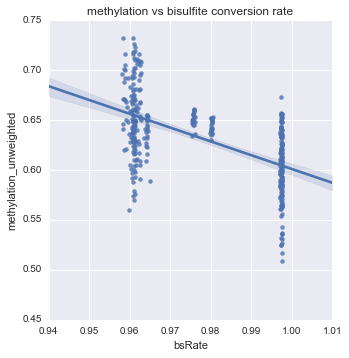

In [15]:
merged = pd.merge(combined2, bs, how='inner')
merged = merged.reset_index(drop=True)
merged = merged.rename(columns = {'totCpG':'Unique_CpGs'})
# Remove all data points with less than 100k in totcpg 
merged = merged[merged['total_reads'] > 100000]
scattermatrix1 = merged.drop(['filename', 'type', 'protocol', 'avgReadCpGs_median'], axis=1)
sns.lmplot(x="bsRate", y="methylation_unweighted",  data=scattermatrix1)
plt.title("methylation vs bisulfite conversion rate")

In [16]:
combined2.head()

,filename,methylation_unweighted,total_reads,type,bio,protocol,avgReadCpGs_mean,avgReadCpGs_median
0,RRBS_normal_B_cell_A1_24_TAAGGCGA.ACAACC,0.691996,11894660.0,normal,normal_B,normal_B_cell_A1_24,5.295301,4.0
1,RRBS_normal_B_cell_A1_24_TAAGGCGA.ACCGCG,0.620106,3744659.0,normal,normal_B,normal_B_cell_A1_24,5.285714,4.0
2,RRBS_normal_B_cell_A1_24_TAAGGCGA.ACGTGG,0.699736,10461874.0,normal,normal_B,normal_B_cell_A1_24,5.453122,5.0
3,RRBS_normal_B_cell_A1_24_TAAGGCGA.ACTCAC,0.763173,14051.0,normal,normal_B,normal_B_cell_A1_24,4.950166,4.0
4,RRBS_normal_B_cell_A1_24_TAAGGCGA.AGGATG,0.732036,21928743.0,normal,normal_B,normal_B_cell_A1_24,5.366276,5.0


In [17]:
merged.head()

,filename,methylation_unweighted,total_reads,type,bio,protocol,avgReadCpGs_mean,avgReadCpGs_median,Unique_CpGs,bsRate
0,RRBS_normal_B_cell_A1_24_TAAGGCGA.ACAACC,0.691996,11894660.0,normal,normal_B,normal_B_cell_A1_24,5.295301,4.0,178825,0.959657
1,RRBS_normal_B_cell_A1_24_TAAGGCGA.ACCGCG,0.620106,3744659.0,normal,normal_B,normal_B_cell_A1_24,5.285714,4.0,86434,0.958634
2,RRBS_normal_B_cell_A1_24_TAAGGCGA.ACGTGG,0.699736,10461874.0,normal,normal_B,normal_B_cell_A1_24,5.453122,5.0,186115,0.958881
4,RRBS_normal_B_cell_A1_24_TAAGGCGA.AGGATG,0.732036,21928743.0,normal,normal_B,normal_B_cell_A1_24,5.366276,5.0,289150,0.958404
5,RRBS_normal_B_cell_A1_24_TAAGGCGA.ATAGCG,0.648127,10864882.0,normal,normal_B,normal_B_cell_A1_24,5.269581,4.0,169511,0.959474


In [18]:
bs.head()

,filename,totCpG,bsRate
0,RRBS_trito_pool_1_TAAGGCGA.ACAACC,995714,0.980280
1,RRBS_trito_pool_1_TAAGGCGA.ACGTGG,705787,0.980081
2,RRBS_trito_pool_1_TAAGGCGA.ACTCAC,865744,0.980305
3,RRBS_trito_pool_1_TAAGGCGA.AGGATG,955160,0.980392
4,RRBS_trito_pool_1_TAAGGCGA.ATAGCG,634455,0.980256


In [19]:
scattermatrix7 = merged.drop(['filename', 'bio', 'avgReadCpGs_median'], axis=1)
y = scattermatrix7.methylation_unweighted # dependent variable
print(y.shape)
X = scattermatrix7.drop(['methylation_unweighted', 'total_reads', 'protocol'], axis=1)
print(X.shape)

categorical_variables = ['type']
for variable in categorical_variables:
    # Fill missing data with the word "Missing"
    X[variable].fillna("Missing", inplace=True)
    # Create array of dummies
    dummies = pd.get_dummies(X[variable], prefix=variable)
    # Update X to include dummies and drop the main variable
    X = pd.concat([X, dummies], axis=1)
    X.drop([variable], axis=1, inplace=True)
    
import statsmodels.api as sm
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for CLL 'RRBS_trito_pool1', predict methylation")
print("Variables: Number of unique CpGs per cell, mean Average Read CpG per cell, BS rate, Cll or Normal B")
est.summary()

(358,)
(358, 4)
Regression results for CLL 'RRBS_trito_pool1', predict methylation
Variables: Number of unique CpGs per cell, mean Average Read CpG per cell, BS rate, Cll or Normal B


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_unweighted   R-squared:                       0.457
Model:                                OLS   Adj. R-squared:                  0.451
Method:                     Least Squares   F-statistic:                     74.21
Date:                    Fri, 08 Jul 2016   Prob (F-statistic):           1.36e-45
Time:                            16:04:53   Log-Likelihood:                 746.26
No. Observations:                     358   AIC:                            -1483.
Df Residuals:                         353   BIC:                            -1463.
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const                1.4335      0.081     17.720      0.000         1.274     1.593
avgReadCpGs_mean    -0.0471      0.012     -3.851      0.000        -0.071    -0.023
Unique_CpGs       5.801e-08    6.7e-09      8.653      0.000      4.48e-08  7.12e-08
bsRate              -1.3260      0.102    -12.938      0.000        -1.528    -1.124
type_CLL             0.7097      0.040     17.715      0.000         0.631     0.789
type_normal          0.7238      0.041     17.685      0.000         0.643     0.804
==============================================================================
Omnibus:                        4.079   Durbin-Watson:                   1.171
Prob(Omnibus):                  0.130   Jarque-Bera (JB):                3.851
Skew:                          -0.247   Prob(JB):                        0.146
Kurtosis:                       3.116   Cond. No.                     6.18e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.03e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [20]:
tritopool = merged[merged["protocol"] == 'trito_pool_1']
tritopool = tritopool.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
tritopoolA = tritopool.set_index("filename")
from itertools import combinations
cc = list(combinations(tritopool.filename,2))
out = pd.DataFrame([tritopoolA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(tritopool.methylation_unweighted, tritopool.methylation_unweighted)), tritopool.filename, tritopool.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs = pd.merge(out, methylation_differences, how='inner')
print(pairs.shape)
pairs = pairs.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs.methylation_difference # dependent variable
X = pairs.drop(['methylation_unweighted', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
print(y.shape)
print(X.shape)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for CLL 'RRBS_trito_pool1', predict \delta methylation")
est.summary()

(210, 7)
(210,)
(210, 3)
Regression results for CLL 'RRBS_trito_pool1', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.003
Model:                                OLS   Adj. R-squared:                 -0.011
Method:                     Least Squares   F-statistic:                    0.2122
Date:                    Fri, 08 Jul 2016   Prob (F-statistic):              0.888
Time:                            16:04:53   Log-Likelihood:                 800.81
No. Observations:                     210   AIC:                            -1594.
Df Residuals:                         206   BIC:                            -1580.
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               -2.1710      5.173     -0.420      0.675       -12.370     8.028
avgReadCpGs_mean     0.0049      0.007      0.700      0.484        -0.009     0.019
Unique_CpGs_mean -2.656e-09   4.88e-09     -0.545      0.587     -1.23e-08  6.96e-09
bsRate_mean          2.1980      5.272      0.417      0.677        -8.196    12.592
==============================================================================
Omnibus:                       12.077   Durbin-Watson:                   2.275
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               11.720
Skew:                           0.527   Prob(JB):                      0.00285
Kurtosis:                       2.521   Cond. No.                     1.72e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.72e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


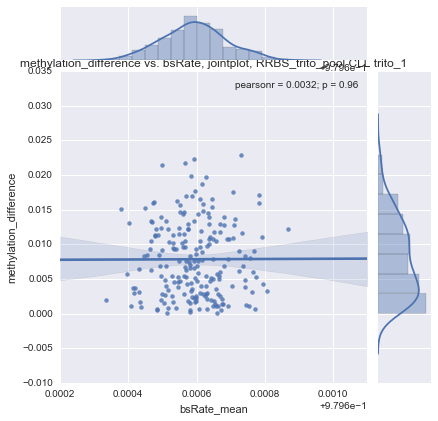

In [21]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, RRBS_trito_pool CLL trito_1")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


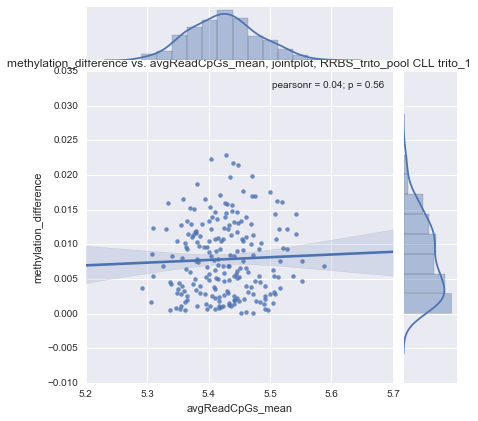

In [22]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, RRBS_trito_pool CLL trito_1")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


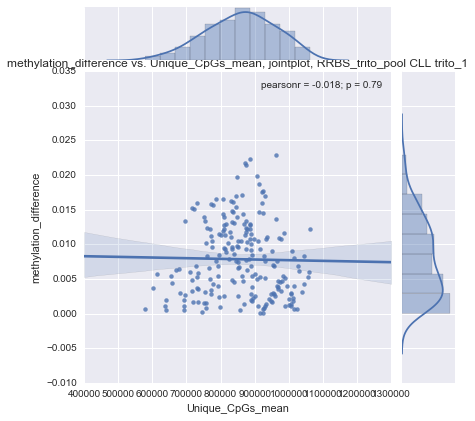

In [23]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, RRBS_trito_pool CLL trito_1")

In [24]:
tritopool2 = merged[merged["protocol"] == 'trito_pool_2']
tritopool2 = tritopool2.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
tritopool2A = tritopool2.set_index("filename")
from itertools import combinations
cc = list(combinations(tritopool2.filename,2))
out = pd.DataFrame([tritopool2A.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(tritopool2.methylation_unweighted, tritopool2.methylation_unweighted)), tritopool2.filename, tritopool2.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs1a = pd.merge(out, methylation_differences, how='inner')
print(pairs1a.shape)
pairs1a = pairs1a.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs1a.methylation_difference # dependent variable
X = pairs1a.drop(['methylation_unweighted', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
print(y.shape)
print(X.shape)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for CLL 'RRBS_trito_pool_2', predict \delta methylation")
est.summary()

(253, 7)
(253,)
(253, 3)
Regression results for CLL 'RRBS_trito_pool_2', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.036
Model:                                OLS   Adj. R-squared:                  0.025
Method:                     Least Squares   F-statistic:                     3.124
Date:                    Fri, 08 Jul 2016   Prob (F-statistic):             0.0265
Time:                            16:04:56   Log-Likelihood:                 934.54
No. Observations:                     253   AIC:                            -1861.
Df Residuals:                         249   BIC:                            -1847.
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const                3.8501      3.720      1.035      0.302        -3.476    11.177
avgReadCpGs_mean     0.0215      0.007      2.882      0.004         0.007     0.036
Unique_CpGs_mean -4.776e-09   3.09e-09     -1.545      0.124     -1.09e-08  1.31e-09
bsRate_mean         -4.0532      3.830     -1.058      0.291       -11.597     3.490
==============================================================================
Omnibus:                       27.220   Durbin-Watson:                   1.512
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.640
Skew:                           0.854   Prob(JB):                     8.17e-08
Kurtosis:                       3.425   Cond. No.                     1.24e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


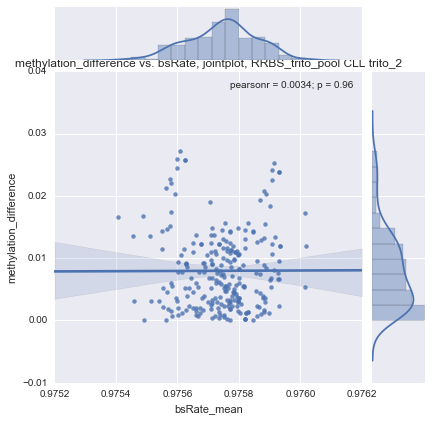

In [25]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs1a, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, RRBS_trito_pool CLL trito_2")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


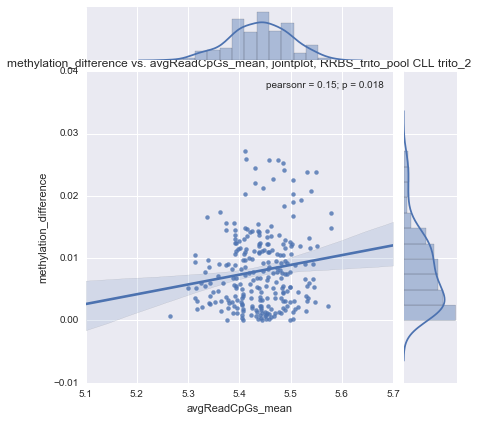

In [26]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs1a, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, RRBS_trito_pool CLL trito_2")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


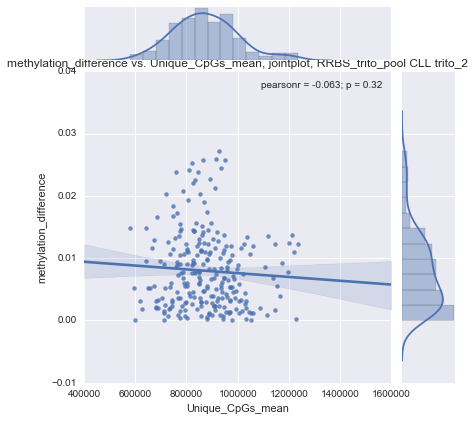

In [27]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs1a, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, RRBS_trito_pool CLL trito_2")

In [28]:
cw154 = merged[merged["protocol"] == 'cw154_Tris_protease']
cw154 = cw154.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
cw154 = cw154.reset_index(drop=True)
cw154A = cw154.set_index("filename")
from itertools import combinations
cc = list(combinations(cw154.filename,2))
out = pd.DataFrame([cw154A.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(cw154.methylation_unweighted, cw154.methylation_unweighted)), cw154.filename, cw154.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs2 = pd.merge(out, methylation_differences, how='inner')
pairs2 = pairs2.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs2.methylation_difference # dependent variable
X = pairs2.drop(['methylation_unweighted', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for CLL 'cw154_Tris_protease', predict \delta methylation")
est.summary()

Regression results for CLL 'cw154_Tris_protease', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.183
Model:                                OLS   Adj. R-squared:                  0.171
Method:                     Least Squares   F-statistic:                     15.33
Date:                    Fri, 08 Jul 2016   Prob (F-statistic):           4.83e-09
Time:                            16:04:59   Log-Likelihood:                 530.18
No. Observations:                     210   AIC:                            -1052.
Df Residuals:                         206   BIC:                            -1039.
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               13.2802      8.774      1.514      0.132        -4.018    30.579
avgReadCpGs_mean     0.0208      0.018      1.179      0.240        -0.014     0.056
Unique_CpGs_mean -6.604e-08   1.25e-08     -5.274      0.000     -9.07e-08 -4.14e-08
bsRate_mean        -13.8821      9.183     -1.512      0.132       -31.988     4.223
==============================================================================
Omnibus:                       10.871   Durbin-Watson:                   1.441
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.619
Skew:                           0.576   Prob(JB):                      0.00300
Kurtosis:                       2.945   Cond. No.                     3.92e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.92e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


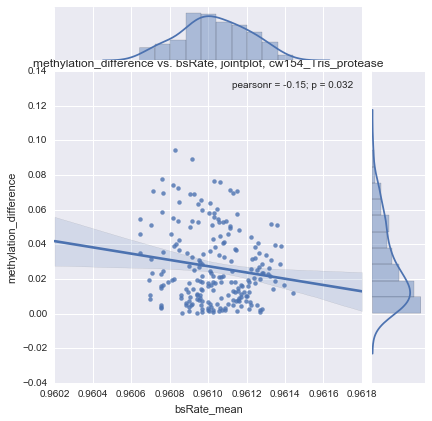

In [29]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs2, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, cw154_Tris_protease")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


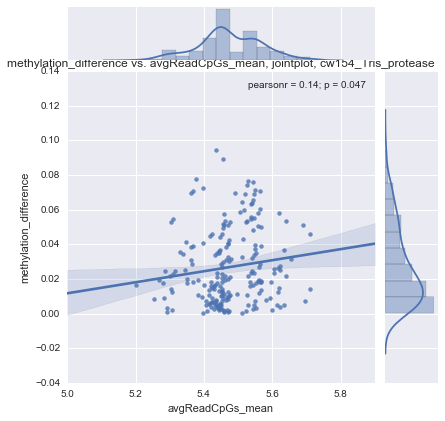

In [30]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs2, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, cw154_Tris_protease")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


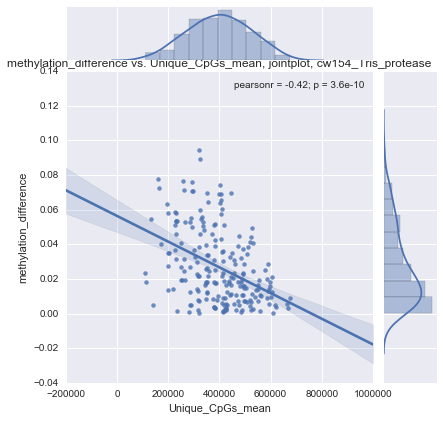

In [31]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs2, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, cw154_Tris_protease")

In [32]:
cw154 = merged[merged["protocol"] == 'cw154_Tris_protease_GR']
cw154 = cw154.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
cw154 = cw154.reset_index(drop=True)
cw154A = cw154.set_index("filename")
from itertools import combinations
cc = list(combinations(cw154.filename,2))
out = pd.DataFrame([cw154A.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(cw154.methylation_unweighted, cw154.methylation_unweighted)), cw154.filename, cw154.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs2a = pd.merge(out, methylation_differences, how='inner')
pairs2a = pairs2a.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs2a.methylation_difference # dependent variable
X = pairs2a.drop(['methylation_unweighted', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for CLL 'RRBS_cw154_Tris_protease_GR', predict \delta methylation")
est.summary()

Regression results for CLL 'RRBS_cw154_Tris_protease_GR', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.137
Model:                                OLS   Adj. R-squared:                  0.125
Method:                     Least Squares   F-statistic:                     10.91
Date:                    Fri, 08 Jul 2016   Prob (F-statistic):           1.11e-06
Time:                            16:05:02   Log-Likelihood:                 560.32
No. Observations:                     210   AIC:                            -1113.
Df Residuals:                         206   BIC:                            -1099.
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              -23.4595      7.821     -2.999      0.003       -38.879    -8.040
avgReadCpGs_mean     0.0184      0.013      1.463      0.145        -0.006     0.043
Unique_CpGs_mean -3.898e-08   8.91e-09     -4.375      0.000     -5.65e-08 -2.14e-08
bsRate_mean         24.3577      8.177      2.979      0.003         8.236    40.480
==============================================================================
Omnibus:                        5.666   Durbin-Watson:                   2.121
Prob(Omnibus):                  0.059   Jarque-Bera (JB):                4.628
Skew:                           0.266   Prob(JB):                       0.0988
Kurtosis:                       2.504   Cond. No.                     5.05e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.05e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


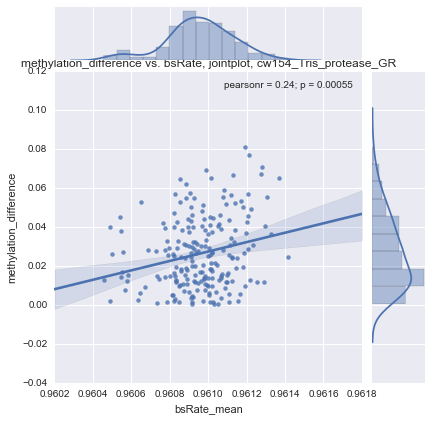

In [33]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs2a, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, cw154_Tris_protease_GR")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


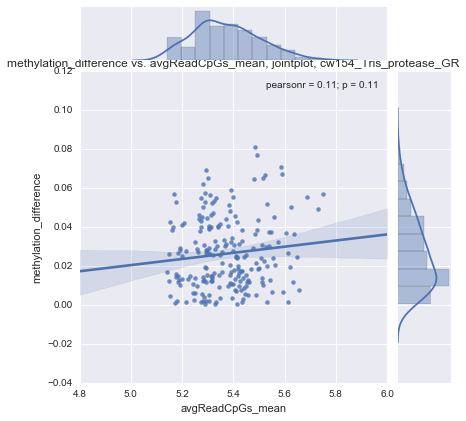

In [34]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs2a, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, cw154_Tris_protease_GR")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


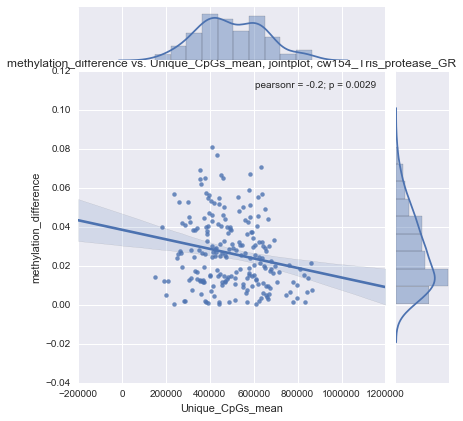

In [35]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs2a, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, cw154_Tris_protease_GR")

In [36]:
# cw154_CutSmart_proteinase_K
cw154 = merged[merged["protocol"] == 'cw154_CutSmart_proteinase_K']
cw154 = cw154.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
cw154 = cw154.reset_index(drop=True)
cw154A = cw154.set_index("filename")
from itertools import combinations
cc = list(combinations(cw154.filename,2))
out = pd.DataFrame([cw154A.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(cw154.methylation_unweighted, cw154.methylation_unweighted)), cw154.filename, cw154.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs2b = pd.merge(out, methylation_differences, how='inner')
pairs2b = pairs2b.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs2b.methylation_difference # dependent variable
X = pairs2b.drop(['methylation_unweighted', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for CLL 'cw154_CutSmart_proteinase_K', predict \delta methylation")
est.summary()

Regression results for CLL 'cw154_CutSmart_proteinase_K', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.452
Model:                                OLS   Adj. R-squared:                  0.444
Method:                     Least Squares   F-statistic:                     56.59
Date:                    Fri, 08 Jul 2016   Prob (F-statistic):           1.00e-26
Time:                            16:05:05   Log-Likelihood:                 649.84
No. Observations:                     210   AIC:                            -1292.
Df Residuals:                         206   BIC:                            -1278.
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              -35.4398      4.078     -8.690      0.000       -43.480   -27.400
avgReadCpGs_mean     0.0254      0.017      1.481      0.140        -0.008     0.059
Unique_CpGs_mean -5.047e-08   6.48e-09     -7.789      0.000     -6.32e-08 -3.77e-08
bsRate_mean         36.6662      4.229      8.670      0.000        28.328    45.004
==============================================================================
Omnibus:                        1.275   Durbin-Watson:                   1.338
Prob(Omnibus):                  0.529   Jarque-Bera (JB):                1.320
Skew:                           0.121   Prob(JB):                        0.517
Kurtosis:                       2.696   Cond. No.                     5.01e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.01e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


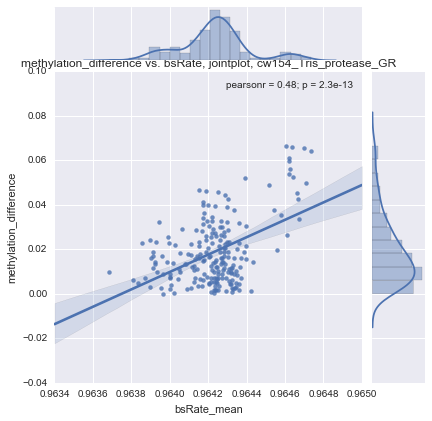

In [37]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs2b, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, cw154_Tris_protease_GR")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


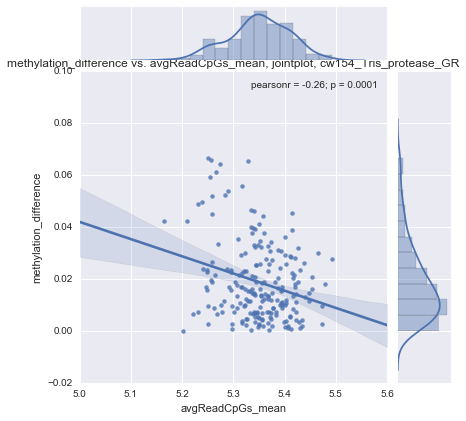

In [38]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs2b, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, cw154_Tris_protease_GR")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


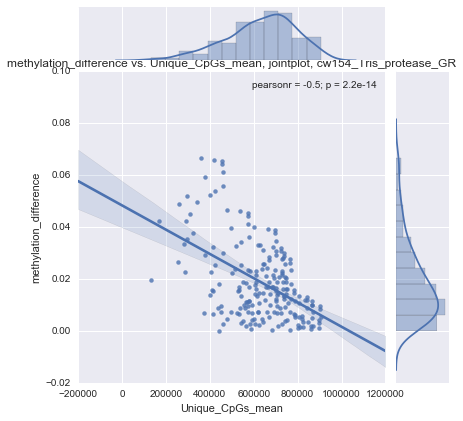

In [39]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs2b, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, cw154_Tris_protease_GR")

In [40]:
merged

,filename,methylation_unweighted,total_reads,type,bio,protocol,avgReadCpGs_mean,avgReadCpGs_median,Unique_CpGs,bsRate
0,RRBS_normal_B_cell_A1_24_TAAGGCGA.ACAACC,0.691996,11894660.0,normal,normal_B,normal_B_cell_A1_24,5.295301,4.0,178825,0.959657
1,RRBS_normal_B_cell_A1_24_TAAGGCGA.ACCGCG,0.620106,3744659.0,normal,normal_B,normal_B_cell_A1_24,5.285714,4.0,86434,0.958634
2,RRBS_normal_B_cell_A1_24_TAAGGCGA.ACGTGG,0.699736,10461874.0,normal,normal_B,normal_B_cell_A1_24,5.453122,5.0,186115,0.958881
4,RRBS_normal_B_cell_A1_24_TAAGGCGA.AGGATG,0.732036,21928743.0,normal,normal_B,normal_B_cell_A1_24,5.366276,5.0,289150,0.958404
5,RRBS_normal_B_cell_A1_24_TAAGGCGA.ATAGCG,0.648127,10864882.0,normal,normal_B,normal_B_cell_A1_24,5.269581,4.0,169511,0.959474
6,RRBS_normal_B_cell_A1_24_TAAGGCGA.ATCGAC,0.716552,18977710.0,normal,normal_B,normal_B_cell_A1_24,5.290053,4.0,277430,0.958963
7,RRBS_normal_B_cell_A1_24_TAAGGCGA.CAAGAG,0.670718,15806813.0,normal,normal_B,normal_B_cell_A1_24,5.337565,4.0,237047,0.958413
8,RRBS_normal_B_cell_A1_24_TAAGGCGA.CATGAC,0.668592,18369519.0,normal,normal_B,normal_B_cell_A1_24,5.232376,4.0,285468,0.959137
10,RRBS_normal_B_cell_A1_24_TAAGGCGA.CGGTAG,0.701418,11929945.0,normal,normal_B,normal_B_cell_A1_24,5.234528,4.0,195729,0.958538
11,RRBS_normal_B_cell_A1_24_TAAGGCGA.CTATTG,0.650146,22563380.0,normal,normal_B,normal_B_cell_A1_24,5.392137,4.0,294801,0.959029


In [41]:
pcell = merged[merged["protocol"] == 'NormalBCD19pCD27pcell1_22_']
pcell = pcell.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
pcell = pcell.reset_index(drop=True)
pcellA = pcell.set_index("filename")
from itertools import combinations  
cc = list(combinations(pcell.filename,2))
out = pd.DataFrame([pcellA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(pcell.methylation_unweighted, pcell.methylation_unweighted)), pcell.filename, pcell.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs3 = pd.merge(out, methylation_differences, how='inner')
pairs3 = pairs3.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs3.methylation_difference # dependent variable
X = pairs3.drop(['methylation_unweighted', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for Normal B 'NormalBCD19pCD27pcell1_22', predict \delta methylation")
est.summary()

Regression results for Normal B 'NormalBCD19pCD27pcell1_22', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.101
Model:                                OLS   Adj. R-squared:                  0.083
Method:                     Least Squares   F-statistic:                     5.609
Date:                    Fri, 08 Jul 2016   Prob (F-statistic):            0.00114
Time:                            16:05:09   Log-Likelihood:                 341.41
No. Observations:                     153   AIC:                            -674.8
Df Residuals:                         149   BIC:                            -662.7
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const             -116.4361     37.123     -3.137      0.002      -189.791   -43.081
avgReadCpGs_mean     0.0795      0.035      2.263      0.025         0.010     0.149
Unique_CpGs_mean -1.209e-08   2.78e-08     -0.435      0.664     -6.71e-08  4.29e-08
bsRate_mean        116.3615     37.212      3.127      0.002        42.831   189.892
==============================================================================
Omnibus:                        8.971   Durbin-Watson:                   1.528
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                9.321
Skew:                           0.604   Prob(JB):                      0.00946
Kurtosis:                       3.024   Cond. No.                     9.28e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.28e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


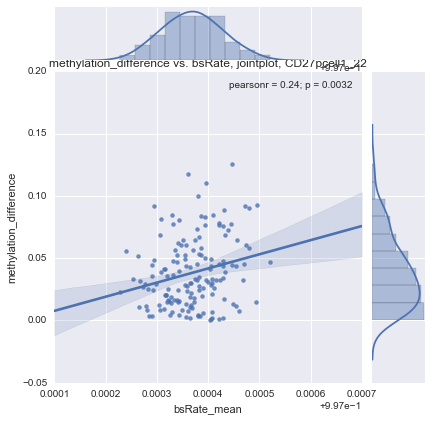

In [42]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs3, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, CD27pcell1_22")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


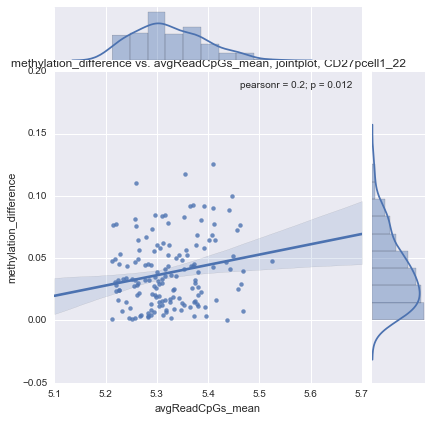

In [43]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs3, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, CD27pcell1_22")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


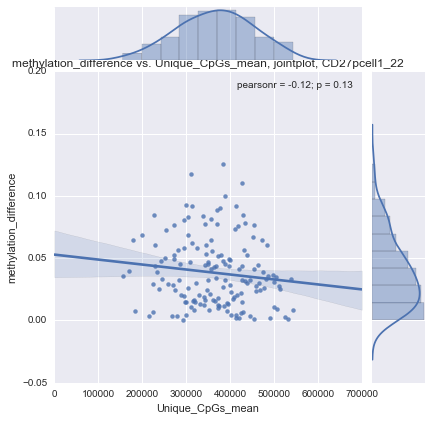

In [44]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs3, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, CD27pcell1_22")

In [45]:
pcell = merged[merged["protocol"] == 'NormalBCD19pCD27pcell23_44']
pcell = pcell.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
pcell = pcell.reset_index(drop=True)
pcellA = pcell.set_index("filename")
from itertools import combinations
cc = list(combinations(pcell.filename,2))
out = pd.DataFrame([pcellA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(pcell.methylation_unweighted, pcell.methylation_unweighted)), pcell.filename, pcell.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs3a = pd.merge(out, methylation_differences, how='inner')
pairs3a = pairs3a.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs3a.methylation_difference # dependent variable
X = pairs3a.drop(['methylation_unweighted', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for Normal B 'NormalBCD19pCD27pcell22_34', predict \delta methylation")
est.summary()

Regression results for Normal B 'NormalBCD19pCD27pcell22_34', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.106
Model:                                OLS   Adj. R-squared:                  0.094
Method:                     Least Squares   F-statistic:                     8.932
Date:                    Fri, 08 Jul 2016   Prob (F-statistic):           1.28e-05
Time:                            16:05:12   Log-Likelihood:                 550.03
No. Observations:                     231   AIC:                            -1092.
Df Residuals:                         227   BIC:                            -1078.
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              -49.4994     37.450     -1.322      0.188      -123.293    24.294
avgReadCpGs_mean     0.0575      0.019      3.007      0.003         0.020     0.095
Unique_CpGs_mean -2.296e-08   2.27e-08     -1.009      0.314     -6.78e-08  2.19e-08
bsRate_mean         49.3532     37.520      1.315      0.190       -24.578   123.285
==============================================================================
Omnibus:                       10.109   Durbin-Watson:                   1.829
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.757
Skew:                           0.524   Prob(JB):                      0.00461
Kurtosis:                       2.863   Cond. No.                     1.28e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.28e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


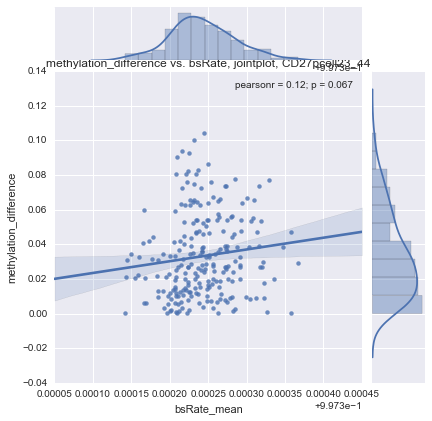

In [46]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs3a, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, CD27pcell23_44")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


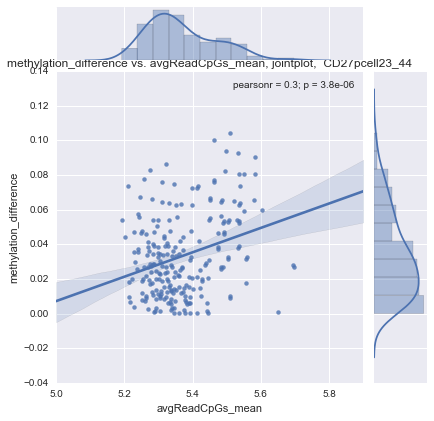

In [47]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs3a, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot,  CD27pcell23_44")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


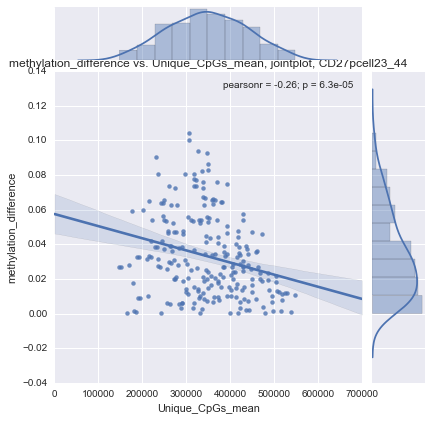

In [48]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs3a, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, CD27pcell23_44")

In [49]:
pcell = merged[merged["protocol"] == 'NormalBCD19pCD27pcell45_66']
pcell = pcell.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
pcell = pcell.reset_index(drop=True)
pcellA = pcell.set_index("filename")
from itertools import combinations
cc = list(combinations(pcell.filename,2))
out = pd.DataFrame([pcellA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(pcell.methylation_unweighted, pcell.methylation_unweighted)), pcell.filename, pcell.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs3b = pd.merge(out, methylation_differences, how='inner')
pairs3b = pairs3b.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs3b.methylation_difference # dependent variable
X = pairs3b.drop(['methylation_unweighted', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for Normal B 'NormalBCD19pCD27pcell45_66', predict \delta methylation")
est.summary()

Regression results for Normal B 'NormalBCD19pCD27pcell45_66', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.385
Model:                                OLS   Adj. R-squared:                  0.327
Method:                     Least Squares   F-statistic:                     6.668
Date:                    Fri, 08 Jul 2016   Prob (F-statistic):            0.00127
Time:                            16:05:14   Log-Likelihood:                 96.760
No. Observations:                      36   AIC:                            -185.5
Df Residuals:                          32   BIC:                            -179.2
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              287.2760    124.543      2.307      0.028        33.590   540.962
avgReadCpGs_mean     0.0375      0.043      0.881      0.385        -0.049     0.124
Unique_CpGs_mean  4.071e-09   1.76e-08      0.231      0.819     -3.19e-08     4e-08
bsRate_mean       -288.1651    124.678     -2.311      0.027      -542.126   -34.204
==============================================================================
Omnibus:                        1.435   Durbin-Watson:                   2.482
Prob(Omnibus):                  0.488   Jarque-Bera (JB):                1.359
Skew:                          -0.429   Prob(JB):                        0.507
Kurtosis:                       2.590   Cond. No.                     3.46e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.46e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


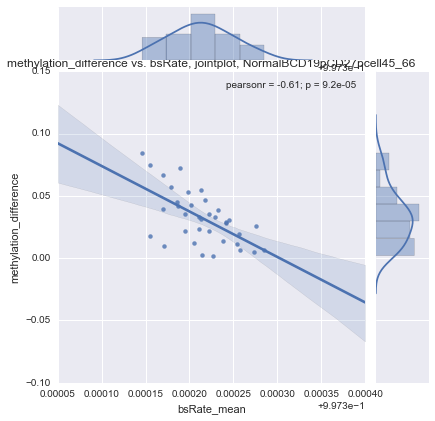

In [50]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs3b, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, NormalBCD19pCD27pcell45_66")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


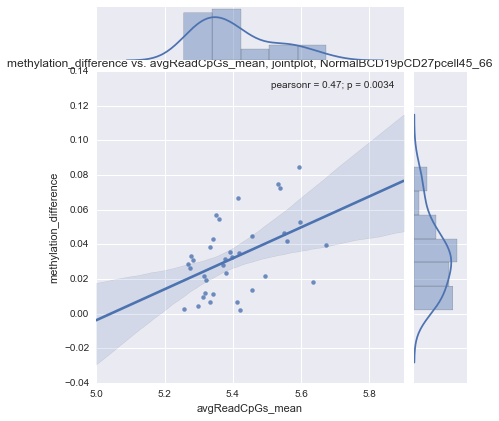

In [51]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs3b, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, NormalBCD19pCD27pcell45_66")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


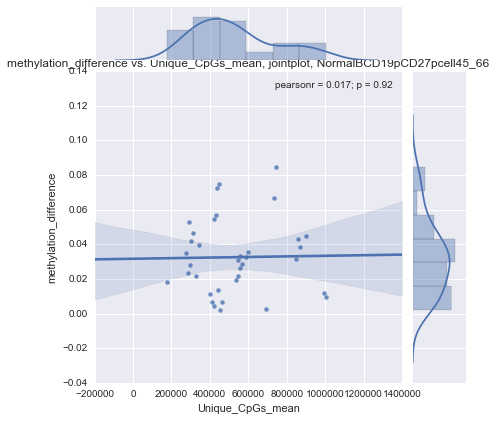

In [52]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs3b, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, NormalBCD19pCD27pcell45_66")

In [53]:
pcell = merged[merged["protocol"] == 'NormalBCD19pCD27pcell67_88']
pcell = pcell.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
pcell = pcell.reset_index(drop=True)
pcellA = pcell.set_index("filename")
from itertools import combinations
cc = list(combinations(pcell.filename,2))
out = pd.DataFrame([pcellA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(pcell.methylation_unweighted, pcell.methylation_unweighted)), pcell.filename, pcell.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs3c = pd.merge(out, methylation_differences, how='inner')
pairs3c = pairs3c.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs3c.methylation_difference # dependent variable
X = pairs3c.drop(['methylation_unweighted', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for Normal B 'NormalBCD19pCD27pcell67_88', predict \delta methylation")
est.summary()

Regression results for Normal B 'NormalBCD19pCD27pcell67_88', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.057
Model:                                OLS   Adj. R-squared:                  0.043
Method:                     Least Squares   F-statistic:                     4.142
Date:                    Fri, 08 Jul 2016   Prob (F-statistic):            0.00707
Time:                            16:05:17   Log-Likelihood:                 566.88
No. Observations:                     210   AIC:                            -1126.
Df Residuals:                         206   BIC:                            -1112.
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               81.7565     24.514      3.335      0.001        33.426   130.087
avgReadCpGs_mean    -0.0398      0.026     -1.542      0.125        -0.091     0.011
Unique_CpGs_mean  2.623e-08   1.44e-08      1.822      0.070     -2.15e-09  5.46e-08
bsRate_mean        -81.7656     24.529     -3.333      0.001      -130.126   -33.405
==============================================================================
Omnibus:                       26.255   Durbin-Watson:                   0.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.164
Skew:                           0.937   Prob(JB):                     1.04e-07
Kurtosis:                       3.404   Cond. No.                     1.06e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


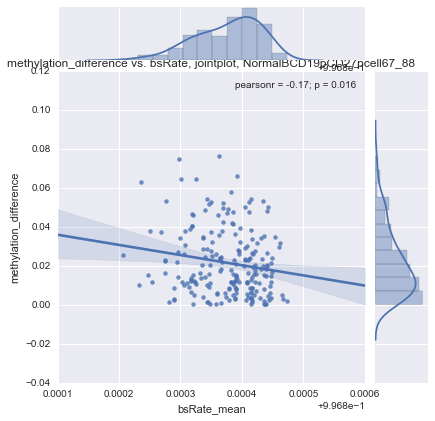

In [54]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs3c, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, NormalBCD19pCD27pcell67_88")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


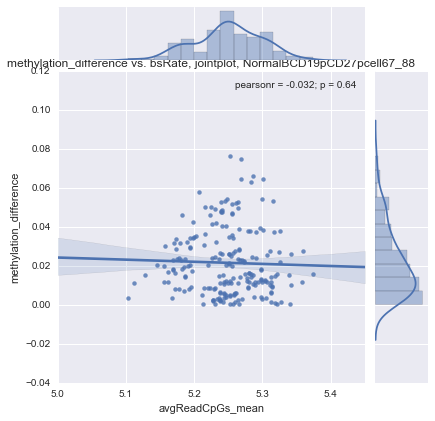

In [55]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs3c, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, NormalBCD19pCD27pcell67_88")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


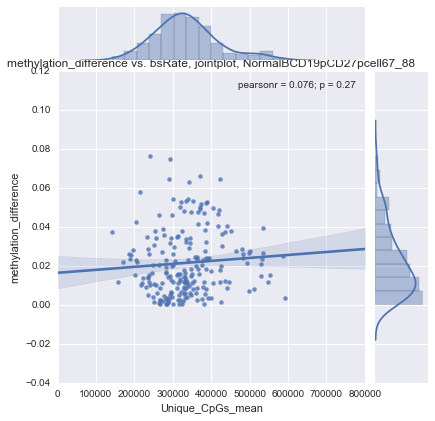

In [56]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs3c, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, NormalBCD19pCD27pcell67_88")

In [57]:
mcell = merged[merged["protocol"] == 'NormalBCD19pCD27mcell1_22_']
mcell = mcell.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
mcell = mcell.reset_index(drop=True)
mcellA = mcell.set_index("filename")
from itertools import combinations
cc = list(combinations(mcell.filename,2))
out = pd.DataFrame([mcellA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(mcell.methylation_unweighted, mcell.methylation_unweighted)), mcell.filename, mcell.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs4 = pd.merge(out, methylation_differences, how='inner')
pairs4 = pairs4.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs4.methylation_difference # dependent variable
X = pairs4.drop(['methylation_unweighted', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'NormalBCD19pCD27mcell1_22', predict \delta methylation")
est.summary()

Regression results for 'NormalBCD19pCD27mcell1_22', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.459
Model:                                OLS   Adj. R-squared:                  0.448
Method:                     Least Squares   F-statistic:                     42.15
Date:                    Fri, 08 Jul 2016   Prob (F-statistic):           8.77e-20
Time:                            16:05:20   Log-Likelihood:                 385.37
No. Observations:                     153   AIC:                            -762.7
Df Residuals:                         149   BIC:                            -750.6
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const             -148.0990     46.964     -3.153      0.002      -240.901   -55.297
avgReadCpGs_mean     0.2332      0.028      8.201      0.000         0.177     0.289
Unique_CpGs_mean  1.394e-07   2.65e-08      5.250      0.000      8.69e-08  1.92e-07
bsRate_mean        147.2034     47.141      3.123      0.002        54.053   240.354
==============================================================================
Omnibus:                       14.563   Durbin-Watson:                   1.334
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                7.216
Skew:                           0.330   Prob(JB):                       0.0271
Kurtosis:                       2.165   Cond. No.                     1.65e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.65e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


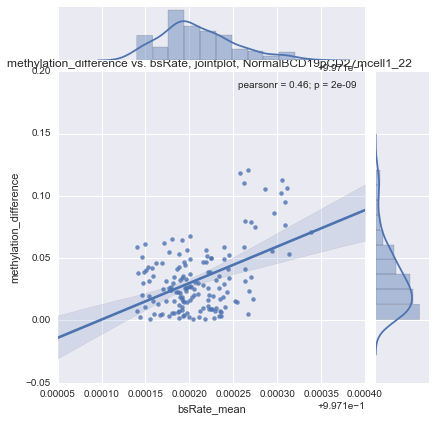

In [58]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs4, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, NormalBCD19pCD27mcell1_22 ")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


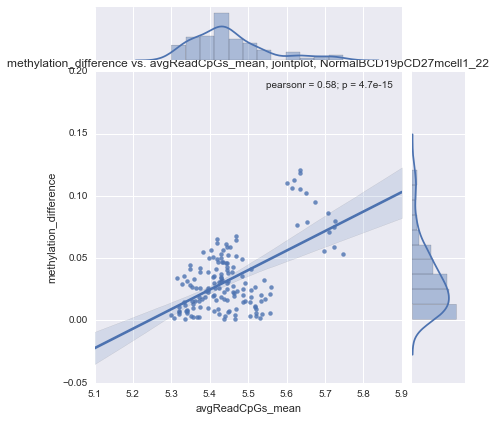

In [59]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs4, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, NormalBCD19pCD27mcell1_22")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


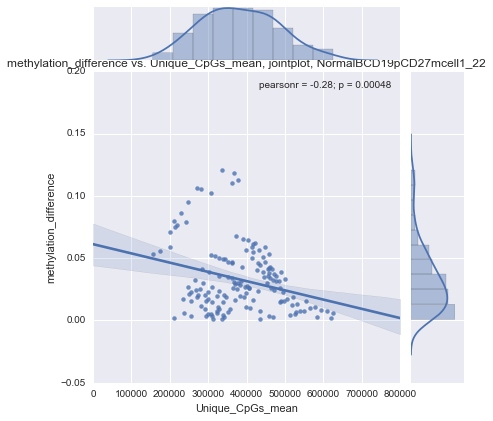

In [60]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs4, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, NormalBCD19pCD27mcell1_22")

In [61]:
mcell = merged[merged["protocol"] == 'NormalBCD19pCD27mcell23_44']
mcell = mcell.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
mcell = mcell.reset_index(drop=True)
mcellA = mcell.set_index("filename")
from itertools import combinations
cc = list(combinations(mcell.filename,2))
out = pd.DataFrame([mcellA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(mcell.methylation_unweighted, mcell.methylation_unweighted)), mcell.filename, mcell.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs4a = pd.merge(out, methylation_differences, how='inner')
pairs4a = pairs4a.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs4a.methylation_difference # dependent variable
X = pairs4a.drop(['methylation_unweighted', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'NormalBCD19pCD27mcell23_44', predict \delta methylation")
est.summary()

Regression results for 'NormalBCD19pCD27mcell23_44', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.070
Model:                                OLS   Adj. R-squared:                  0.053
Method:                     Least Squares   F-statistic:                     4.192
Date:                    Fri, 08 Jul 2016   Prob (F-statistic):            0.00685
Time:                            16:05:23   Log-Likelihood:                 479.12
No. Observations:                     171   AIC:                            -950.2
Df Residuals:                         167   BIC:                            -937.7
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              -69.1096     43.629     -1.584      0.115      -155.244    17.025
avgReadCpGs_mean    -0.1001      0.031     -3.206      0.002        -0.162    -0.038
Unique_CpGs_mean -4.984e-08   2.06e-08     -2.421      0.017     -9.05e-08 -9.19e-09
bsRate_mean         69.8564     43.739      1.597      0.112       -16.497   156.210
==============================================================================
Omnibus:                        9.337   Durbin-Watson:                   1.399
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                9.857
Skew:                           0.588   Prob(JB):                      0.00724
Kurtosis:                       2.948   Cond. No.                     1.91e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.91e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


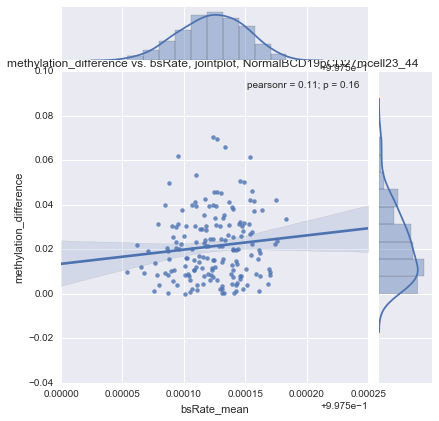

In [62]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs4a, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, NormalBCD19pCD27mcell23_44 ")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


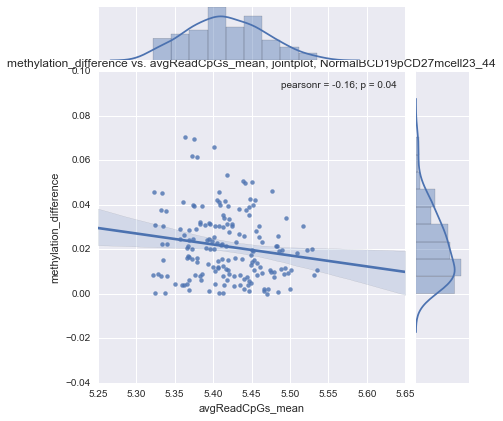

In [63]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs4a, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, NormalBCD19pCD27mcell23_44")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


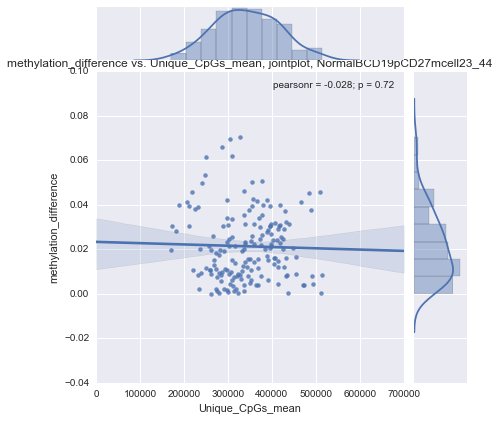

In [64]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs4a, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, NormalBCD19pCD27mcell23_44")

In [65]:
mcell = merged[merged["protocol"] == 'NormalBCD19pCD27mcell45_66']
mcell = mcell.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
mcell = mcell.reset_index(drop=True)
mcellA = mcell.set_index("filename")
from itertools import combinations
cc = list(combinations(mcell.filename,2))
out = pd.DataFrame([mcellA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(mcell.methylation_unweighted, mcell.methylation_unweighted)), mcell.filename, mcell.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs4b = pd.merge(out, methylation_differences, how='inner')
pairs4b = pairs4b.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs4b.methylation_difference # dependent variable
X = pairs4b.drop(['methylation_unweighted', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'NormalBCD19pCD27mcell23_44', predict \delta methylation")
est.summary()

Regression results for 'NormalBCD19pCD27mcell23_44', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.339
Model:                                OLS   Adj. R-squared:                  0.324
Method:                     Least Squares   F-statistic:                     22.53
Date:                    Fri, 08 Jul 2016   Prob (F-statistic):           7.69e-12
Time:                            16:05:26   Log-Likelihood:                 352.27
No. Observations:                     136   AIC:                            -696.5
Df Residuals:                         132   BIC:                            -684.9
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               61.2886     47.409      1.293      0.198       -32.491   155.069
avgReadCpGs_mean     0.2237      0.028      7.903      0.000         0.168     0.280
Unique_CpGs_mean  1.393e-07   3.03e-08      4.595      0.000      7.93e-08  1.99e-07
bsRate_mean        -62.6685     47.529     -1.319      0.190      -156.685    31.348
==============================================================================
Omnibus:                        3.998   Durbin-Watson:                   1.192
Prob(Omnibus):                  0.135   Jarque-Bera (JB):                3.913
Skew:                           0.414   Prob(JB):                        0.141
Kurtosis:                       2.925   Cond. No.                     1.55e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.55e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


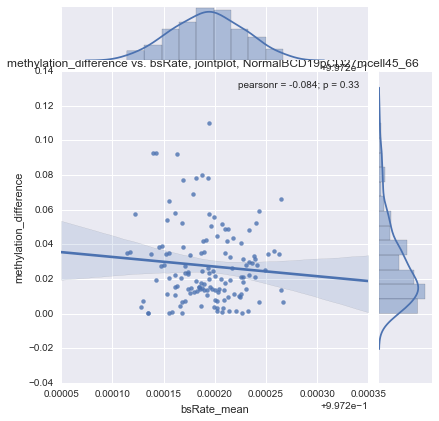

In [66]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs4b, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, NormalBCD19pCD27mcell45_66 ")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


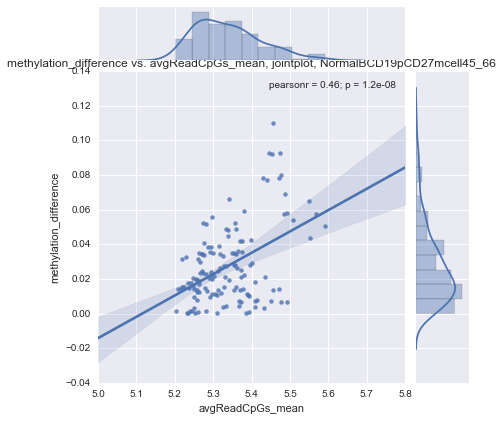

In [67]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs4b, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, NormalBCD19pCD27mcell45_66")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


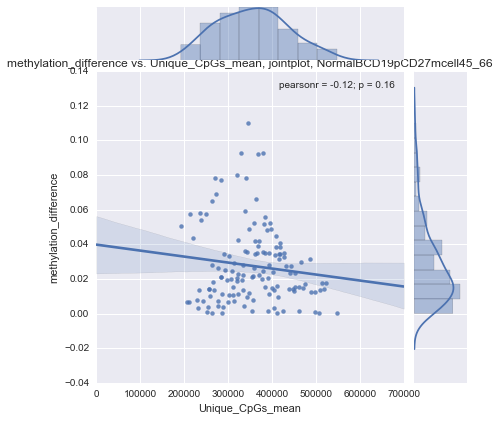

In [68]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs4b, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, NormalBCD19pCD27mcell45_66")

In [69]:
mcell = merged[merged["protocol"] == 'NormalBCD19pCD27mcell67_88']
mcell = mcell.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
mcell = mcell.reset_index(drop=True)
mcellA = mcell.set_index("filename")
from itertools import combinations
cc = list(combinations(mcell.filename,2))
out = pd.DataFrame([mcellA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(mcell.methylation_unweighted, mcell.methylation_unweighted)), mcell.filename, mcell.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs4c = pd.merge(out, methylation_differences, how='inner')
pairs4c = pairs4c.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs4c.methylation_difference # dependent variable
X = pairs4c.drop(['methylation_unweighted', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'NormalBCD19pCD27mcell23_44', predict \delta methylation")
est.summary()

Regression results for 'NormalBCD19pCD27mcell23_44', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.150
Model:                                OLS   Adj. R-squared:                  0.138
Method:                     Least Squares   F-statistic:                     12.11
Date:                    Fri, 08 Jul 2016   Prob (F-statistic):           2.47e-07
Time:                            16:05:29   Log-Likelihood:                 518.92
No. Observations:                     210   AIC:                            -1030.
Df Residuals:                         206   BIC:                            -1016.
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               -5.4777     48.091     -0.114      0.909      -100.292    89.336
avgReadCpGs_mean     0.1170      0.022      5.237      0.000         0.073     0.161
Unique_CpGs_mean  4.107e-08   2.13e-08      1.929      0.055     -9.17e-10  8.31e-08
bsRate_mean          4.8612     48.220      0.101      0.920       -90.207    99.929
==============================================================================
Omnibus:                        7.984   Durbin-Watson:                   1.882
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                8.027
Skew:                           0.477   Prob(JB):                       0.0181
Kurtosis:                       3.085   Cond. No.                     2.04e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.04e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


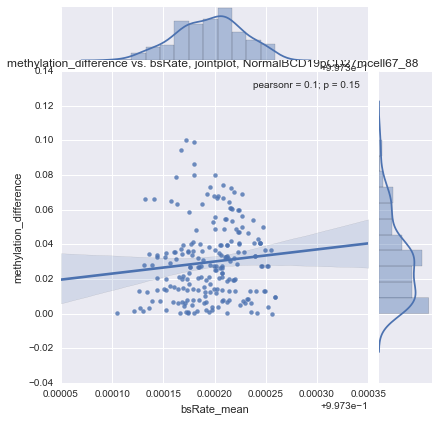

In [70]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs4c, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, NormalBCD19pCD27mcell67_88 ")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


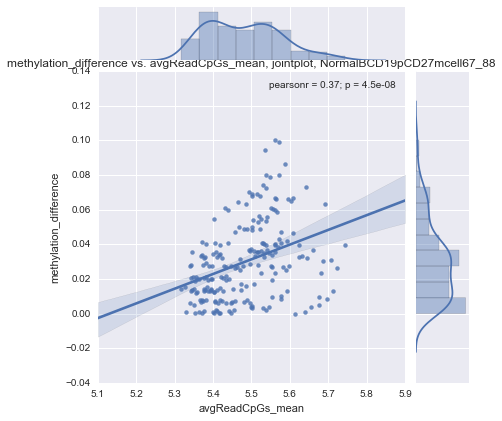

In [71]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs4c, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, NormalBCD19pCD27mcell67_88")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


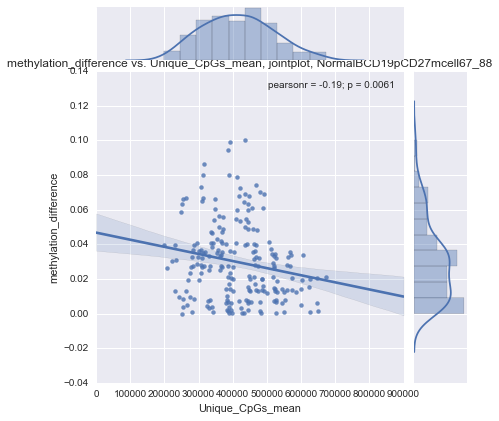

In [72]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs4c, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, NormalBCD19pCD27mcell67_88")

In [73]:
normb = merged[merged["protocol"] == 'normal_B_cell_A1_24']
normb = normb.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
normb = normb.reset_index(drop=True)
normbA = normb.set_index("filename")
from itertools import combinations
cc = list(combinations(normb.filename,2))
out = pd.DataFrame([normbA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(normb.methylation_unweighted, normb.methylation_unweighted)), normb.filename, normb.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs5 = pd.merge(out, methylation_differences, how='inner')
pairs5 = pairs5.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs5.methylation_difference # dependent variable
X = pairs5.drop(['methylation_unweighted', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'normal_B_cell_A1_24', predict \delta methylation")
est.summary()

Regression results for 'normal_B_cell_A1_24', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.009
Model:                                OLS   Adj. R-squared:                 -0.007
Method:                     Least Squares   F-statistic:                    0.5565
Date:                    Fri, 08 Jul 2016   Prob (F-statistic):              0.644
Time:                            16:05:32   Log-Likelihood:                 434.74
No. Observations:                     190   AIC:                            -861.5
Df Residuals:                         186   BIC:                            -848.5
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const                8.0254      6.609      1.214      0.226        -5.014    21.065
avgReadCpGs_mean     0.0179      0.035      0.510      0.610        -0.051     0.087
Unique_CpGs_mean -1.006e-08   5.13e-08     -0.196      0.845     -1.11e-07  9.12e-08
bsRate_mean         -8.4297      6.913     -1.219      0.224       -22.067     5.208
==============================================================================
Omnibus:                       12.503   Durbin-Watson:                   1.687
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.768
Skew:                           0.657   Prob(JB):                      0.00102
Kurtosis:                       2.892   Cond. No.                     1.17e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.17e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


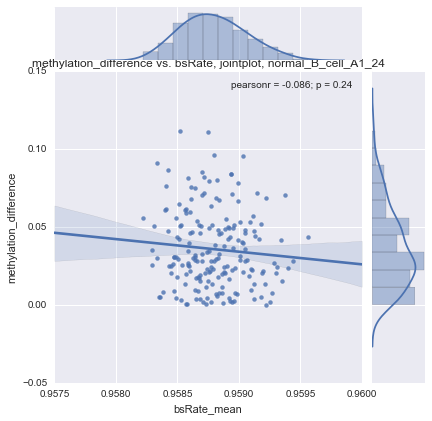

In [74]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs5, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, normal_B_cell_A1_24")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


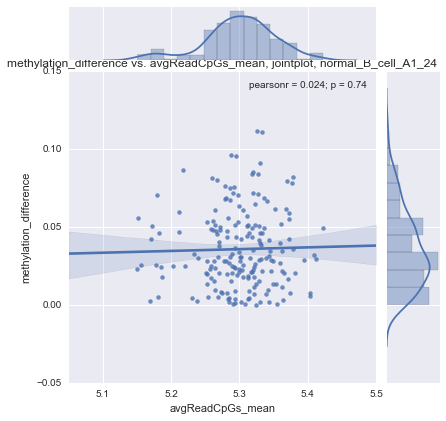

In [75]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs5, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, normal_B_cell_A1_24")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


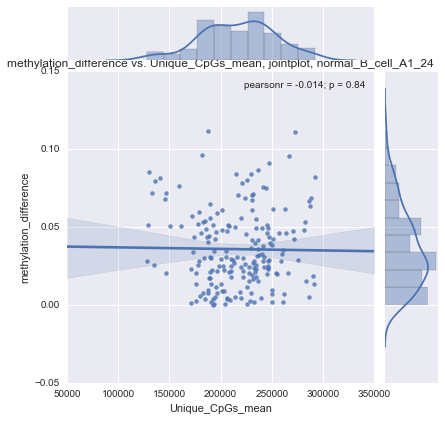

In [76]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs5, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, normal_B_cell_A1_24")

In [77]:
normb = merged[merged["protocol"] == 'normal_B_cell_B1_24']
normb = normb.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
normb = normb.reset_index(drop=True)
normbA = normb.set_index("filename")
from itertools import combinations
cc = list(combinations(normb.filename,2))
out = pd.DataFrame([normbA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(normb.methylation_unweighted, normb.methylation_unweighted)), normb.filename, normb.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs5a = pd.merge(out, methylation_differences, how='inner')
pairs5a = pairs5a.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs5a.methylation_difference # dependent variable
X = pairs5a.drop(['methylation_unweighted', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'normal_B_cell_B1_24', predict \delta methylation")
est.summary()

Regression results for 'normal_B_cell_B1_24', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.027
Model:                                OLS   Adj. R-squared:                  0.011
Method:                     Least Squares   F-statistic:                     1.731
Date:                    Fri, 08 Jul 2016   Prob (F-statistic):              0.162
Time:                            16:05:35   Log-Likelihood:                 380.60
No. Observations:                     190   AIC:                            -753.2
Df Residuals:                         186   BIC:                            -740.2
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              -26.8879     20.939     -1.284      0.201       -68.196    14.420
avgReadCpGs_mean    -0.0882      0.039     -2.271      0.024        -0.165    -0.012
Unique_CpGs_mean -1.628e-08   2.19e-08     -0.743      0.458     -5.95e-08   2.7e-08
bsRate_mean         28.5286     21.926      1.301      0.195       -14.726    71.783
==============================================================================
Omnibus:                       14.614   Durbin-Watson:                   1.626
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               10.052
Skew:                           0.437   Prob(JB):                      0.00656
Kurtosis:                       2.288   Cond. No.                     5.83e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.83e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


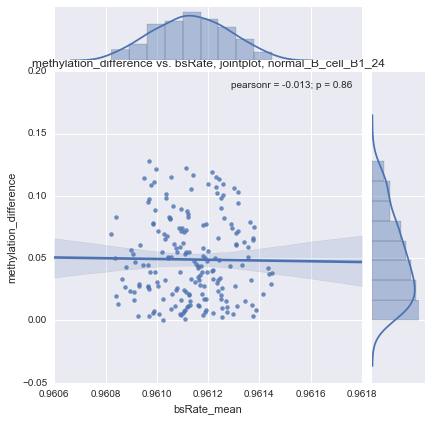

In [78]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs5a, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, normal_B_cell_B1_24")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


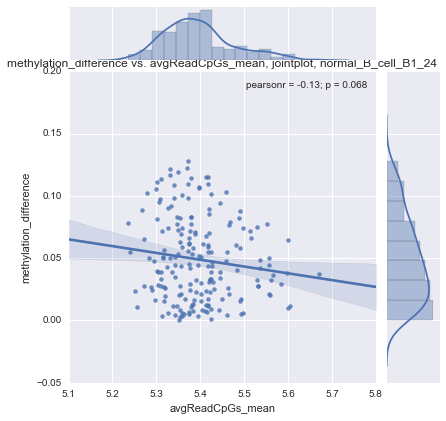

In [79]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs5a, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, normal_B_cell_B1_24")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


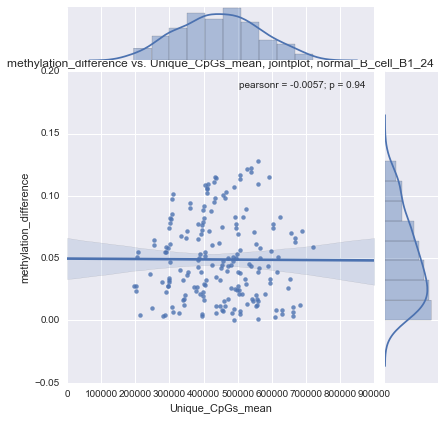

In [80]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs5a, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, normal_B_cell_B1_24")

In [81]:
normb = merged[merged["protocol"] == 'normal_B_cell_C1_24']
normb = normb.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
normb = normb.reset_index(drop=True)
normbA = normb.set_index("filename")
from itertools import combinations
cc = list(combinations(normb.filename,2))
out = pd.DataFrame([normbA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(normb.methylation_unweighted, normb.methylation_unweighted)), normb.filename, normb.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs5b = pd.merge(out, methylation_differences, how='inner')
pairs5b = pairs5b.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs5b.methylation_difference # dependent variable
X = pairs5b.drop(['methylation_unweighted', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'normal_B_cell_C1_24', predict \delta methylation")
est.summary()

Regression results for 'normal_B_cell_C1_24', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.016
Model:                                OLS   Adj. R-squared:                  0.003
Method:                     Least Squares   F-statistic:                     1.244
Date:                    Fri, 08 Jul 2016   Prob (F-statistic):              0.295
Time:                            16:05:38   Log-Likelihood:                 470.32
No. Observations:                     231   AIC:                            -932.6
Df Residuals:                         227   BIC:                            -918.9
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              -10.8882     17.324     -0.629      0.530       -45.024    23.248
avgReadCpGs_mean    -0.0617      0.047     -1.304      0.194        -0.155     0.032
Unique_CpGs_mean -1.209e-08   1.04e-08     -1.162      0.247     -3.26e-08  8.42e-09
bsRate_mean         11.7216     18.158      0.646      0.519       -24.057    47.501
==============================================================================
Omnibus:                       19.896   Durbin-Watson:                   1.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.257
Skew:                           0.558   Prob(JB):                     0.000295
Kurtosis:                       2.335   Cond. No.                     9.25e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.25e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


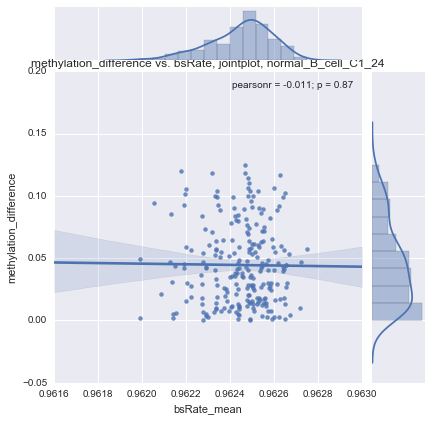

In [82]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs5b, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, normal_B_cell_C1_24")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


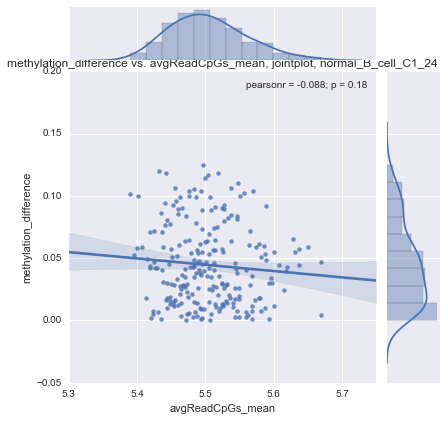

In [83]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs5b, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, normal_B_cell_C1_24")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


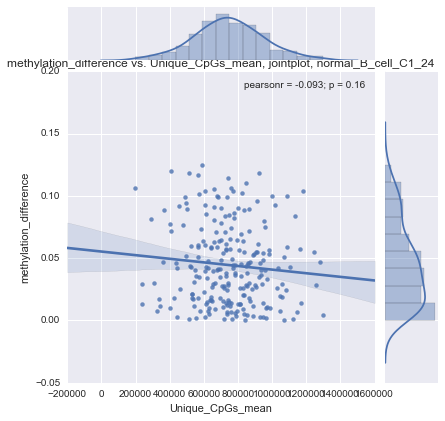

In [84]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs5b, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, normal_B_cell_C1_24")

In [85]:
normb = merged[merged["protocol"] == 'normal_B_cell_D1_24']
normb = normb.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
normb = normb.reset_index(drop=True)
normbA = normb.set_index("filename")
from itertools import combinations
cc = list(combinations(normb.filename,2))
out = pd.DataFrame([normbA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(normb.methylation_unweighted, normb.methylation_unweighted)), normb.filename, normb.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs5c = pd.merge(out, methylation_differences, how='inner')
pairs5c = pairs5c.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs5c.methylation_difference # dependent variable
X = pairs5c.drop(['methylation_unweighted', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'normal_B_cell_D1_24', predict \delta methylation")
est.summary()

Regression results for 'normal_B_cell_D1_24', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.241
Model:                                OLS   Adj. R-squared:                  0.170
Method:                     Least Squares   F-statistic:                     3.383
Date:                    Fri, 08 Jul 2016   Prob (F-statistic):             0.0300
Time:                            16:05:41   Log-Likelihood:                 85.716
No. Observations:                      36   AIC:                            -163.4
Df Residuals:                          32   BIC:                            -157.1
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               17.9503     27.055      0.663      0.512       -37.158    73.059
avgReadCpGs_mean    -0.1749      0.058     -3.004      0.005        -0.294    -0.056
Unique_CpGs_mean  3.622e-08   2.71e-08      1.335      0.191      -1.9e-08  9.15e-08
bsRate_mean        -17.6555     28.176     -0.627      0.535       -75.048    39.736
==============================================================================
Omnibus:                        2.534   Durbin-Watson:                   2.132
Prob(Omnibus):                  0.282   Jarque-Bera (JB):                2.093
Skew:                          -0.585   Prob(JB):                        0.351
Kurtosis:                       2.843   Cond. No.                     7.43e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.43e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


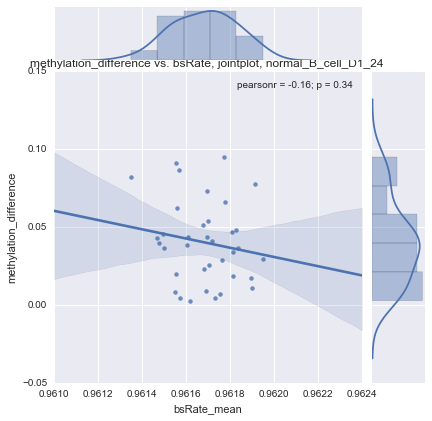

In [86]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs5c, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, normal_B_cell_D1_24 ")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


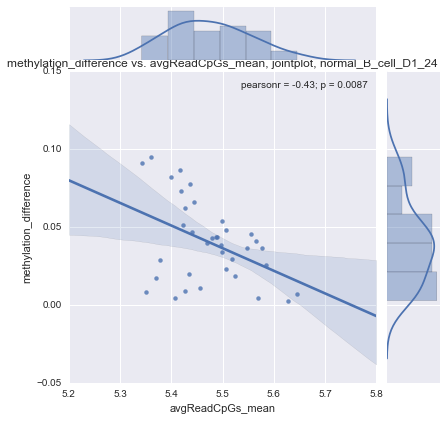

In [87]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs5c, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, normal_B_cell_D1_24")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


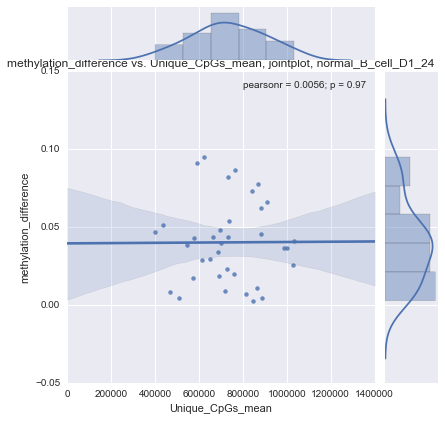

In [88]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs5c, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, normal_B_cell_D1_24")

In [89]:
normb = merged[merged["protocol"] == 'normal_B_cell_G1_22']
normb = normb.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
normb = normb.reset_index(drop=True)
normbA = normb.set_index("filename")
from itertools import combinations
cc = list(combinations(normb.filename,2))
out = pd.DataFrame([normbA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(normb.methylation_unweighted, normb.methylation_unweighted)), normb.filename, normb.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs5d = pd.merge(out, methylation_differences, how='inner')
pairs5d = pairs5d.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs5d.methylation_difference # dependent variable
X = pairs5d.drop(['methylation_unweighted', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'normal_B_cell_G1_22', predict \delta methylation")
est.summary()

Regression results for 'normal_B_cell_G1_22', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.059
Model:                                OLS   Adj. R-squared:                  0.042
Method:                     Least Squares   F-statistic:                     3.492
Date:                    Fri, 08 Jul 2016   Prob (F-statistic):             0.0170
Time:                            16:05:44   Log-Likelihood:                 342.48
No. Observations:                     171   AIC:                            -677.0
Df Residuals:                         167   BIC:                            -664.4
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const                6.1267     15.422      0.397      0.692       -24.320    36.573
avgReadCpGs_mean     0.1638      0.057      2.892      0.004         0.052     0.276
Unique_CpGs_mean  1.148e-08   2.38e-08      0.483      0.630     -3.54e-08  5.84e-08
bsRate_mean         -7.2579     16.238     -0.447      0.655       -39.317    24.801
==============================================================================
Omnibus:                        9.148   Durbin-Watson:                   1.747
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                9.707
Skew:                           0.567   Prob(JB):                      0.00780
Kurtosis:                       2.727   Cond. No.                     5.53e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.53e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


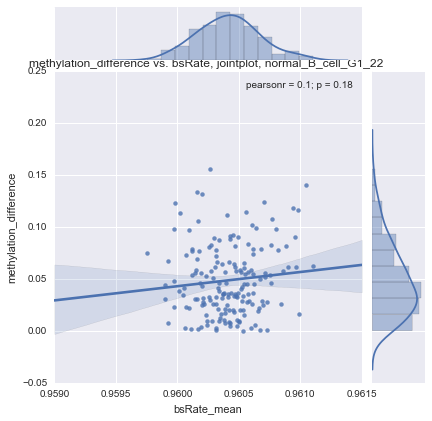

In [90]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs5d, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, normal_B_cell_G1_22 ")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


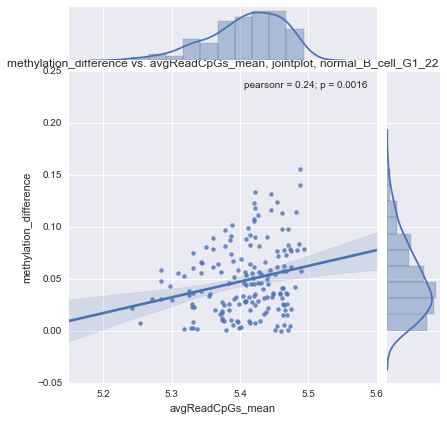

In [91]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs5d, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, normal_B_cell_G1_22")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


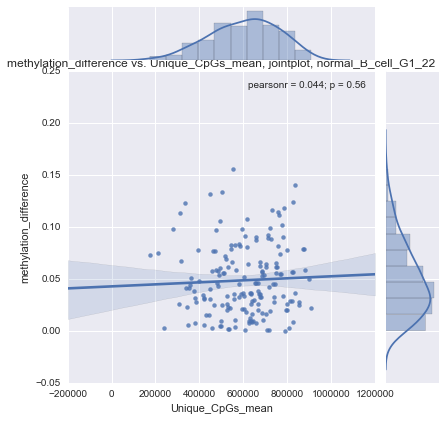

In [92]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs5d, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, normal_B_cell_G1_22")

In [93]:
normb = merged[merged["protocol"] == 'normal_B_cell_H1_22']
normb = normb.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
normb = normb.reset_index(drop=True)
normbA = normb.set_index("filename")
from itertools import combinations
cc = list(combinations(normb.filename,2))
out = pd.DataFrame([normbA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(normb.methylation_unweighted, normb.methylation_unweighted)), normb.filename, normb.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs5e = pd.merge(out, methylation_differences, how='inner')
pairs5e = pairs5e.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs5e.methylation_difference # dependent variable
X = pairs5e.drop(['methylation_unweighted', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'normal_B_cell_H1_22', predict \delta methylation")
est.summary()

Regression results for 'normal_B_cell_H1_22', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.071
Model:                                OLS   Adj. R-squared:                  0.047
Method:                     Least Squares   F-statistic:                     2.955
Date:                    Fri, 08 Jul 2016   Prob (F-statistic):             0.0355
Time:                            16:05:46   Log-Likelihood:                 246.39
No. Observations:                     120   AIC:                            -484.8
Df Residuals:                         116   BIC:                            -473.6
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               26.9121     24.688      1.090      0.278       -21.986    75.811
avgReadCpGs_mean     0.1334      0.057      2.350      0.020         0.021     0.246
Unique_CpGs_mean -3.643e-09   3.36e-08     -0.108      0.914     -7.02e-08  6.29e-08
bsRate_mean        -28.6968     25.769     -1.114      0.268       -79.736    22.342
==============================================================================
Omnibus:                        6.663   Durbin-Watson:                   1.619
Prob(Omnibus):                  0.036   Jarque-Bera (JB):                6.817
Skew:                           0.582   Prob(JB):                       0.0331
Kurtosis:                       2.906   Cond. No.                     6.56e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.56e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


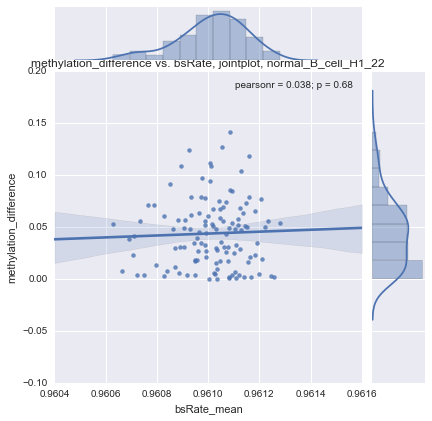

In [94]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs5e, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, normal_B_cell_H1_22")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


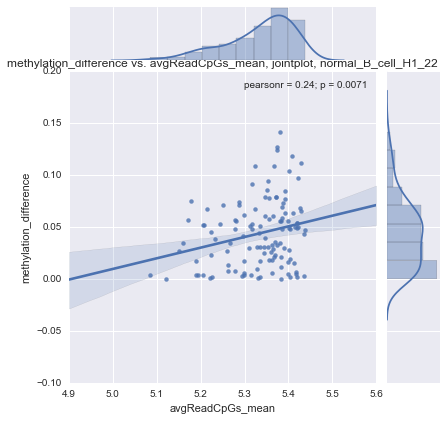

In [95]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs5e, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, normal_B_cell_H1_22")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


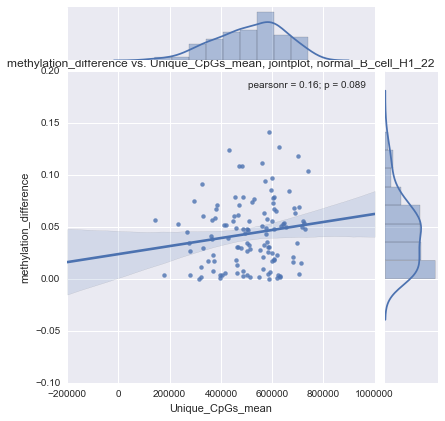

In [96]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs5e, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, normal_B_cell_H1_22")

In [97]:
pairs['type'] = str('CLL')
pairs1a['type'] = str('CLL')
pairs2['type'] = str('CLL')
pairs2a['type'] = str('CLL')
pairs2b['type'] = str('CLL')
pairs3['type'] = str('CLL')
pairs3a['type'] = str('normal')
pairs3b['type'] = str('normal')
pairs3c['type'] = str('normal')
pairs4['type'] = str('normal')
pairs4a['type'] = str('normal')
pairs4b['type'] = str('normal')
pairs4c['type'] = str('normal')
pairs5['type'] = str('normal')
pairs5a['type'] = str('normal')
pairs5b['type'] = str('normal')
pairs5c['type'] = str('normal')
pairs5d['type'] = str('normal')
pairs5e['type'] = str('normal')

frames22 = [pairs, pairs2, pairs3, pairs4]
total_pairs = pd.concat(frames22)
y = total_pairs.methylation_difference # dependent variable
X = total_pairs.drop(['methylation_unweighted', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)

categorical_variables = ['type']
for variable in categorical_variables:
    # Fill missing data with the word "Missing"
    X[variable].fillna("Missing", inplace=True)
    # Create array of dummies
    dummies = pd.get_dummies(X[variable], prefix=variable)
    # Update X to include dummies and drop the main variable
    X = pd.concat([X, dummies], axis=1)
    X.drop([variable], axis=1, inplace=True)
    
X = X.drop(['type_normal'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results, all batches 'Normal B' vs 'CLL' , predict \delta methylation")
est.summary()

Regression results, all batches 'Normal B' vs 'CLL' , predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.307
Model:                                OLS   Adj. R-squared:                  0.303
Method:                     Least Squares   F-statistic:                     79.82
Date:                    Fri, 08 Jul 2016   Prob (F-statistic):           4.47e-56
Time:                            16:05:49   Log-Likelihood:                 1805.8
No. Observations:                     726   AIC:                            -3602.
Df Residuals:                         721   BIC:                            -3579.
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               -0.6997      0.105     -6.643      0.000        -0.907    -0.493
avgReadCpGs_mean     0.0514      0.009      5.531      0.000         0.033     0.070
Unique_CpGs_mean -5.159e-08   3.29e-09    -15.683      0.000     -5.81e-08 -4.51e-08
bsRate_mean          0.4734      0.069      6.822      0.000         0.337     0.610
type_CLL             0.0102      0.002      4.099      0.000         0.005     0.015
==============================================================================
Omnibus:                      104.826   Durbin-Watson:                   1.463
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              181.497
Skew:                           0.897   Prob(JB):                     3.88e-40
Kurtosis:                       4.667   Cond. No.                     9.50e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.5e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


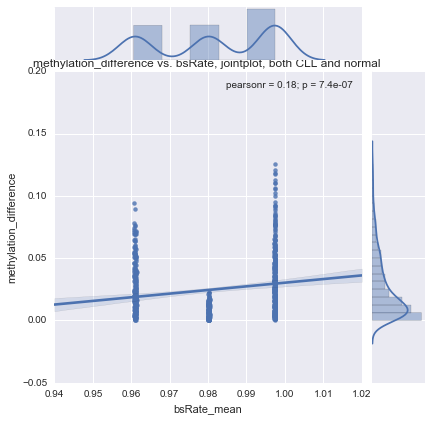

In [98]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=total_pairs, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, both CLL and normal ")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


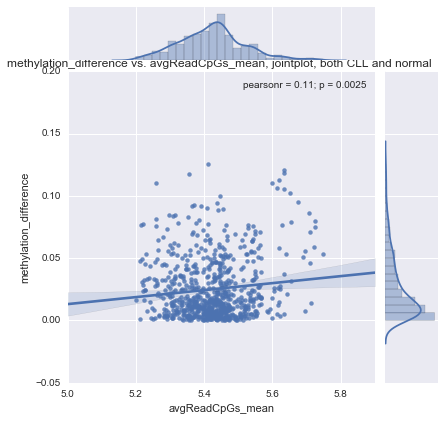

In [99]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=total_pairs, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, both CLL and normal ")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


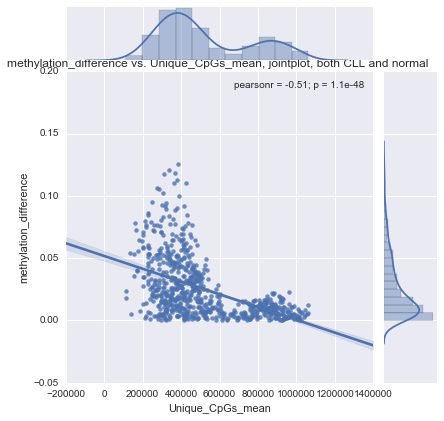

In [100]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=total_pairs, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, both CLL and normal ")

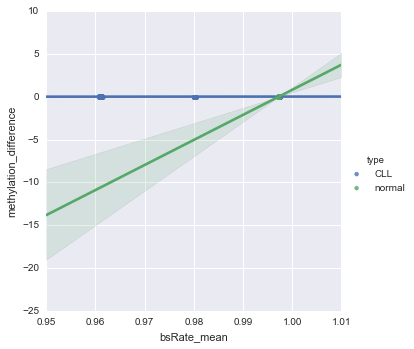

In [101]:
sns.lmplot(x="bsRate_mean", y="methylation_difference",  data=total_pairs, hue='type')

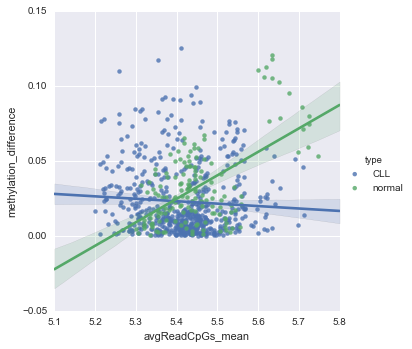

In [102]:
sns.lmplot(x="avgReadCpGs_mean", y="methylation_difference",  data=total_pairs, hue='type')

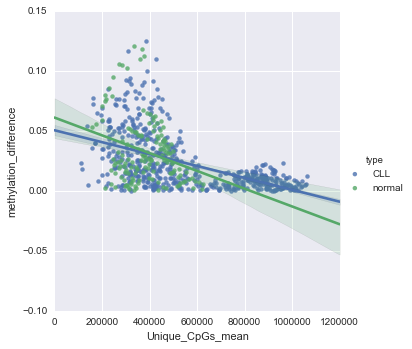

In [103]:
sns.lmplot(x="Unique_CpGs_mean", y="methylation_difference",  data=total_pairs, hue='type')

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:8: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


Random Forest model score is 0.913346539006


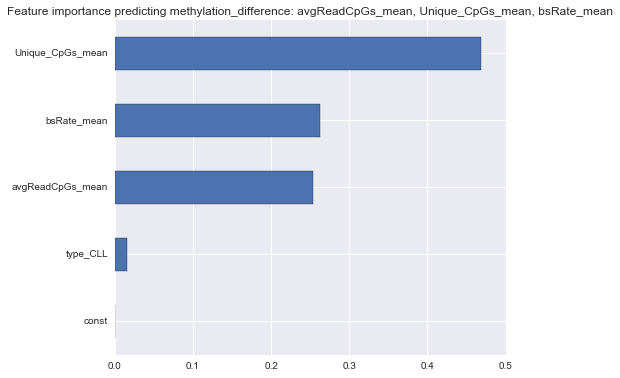

In [104]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

model = RandomForestRegressor(n_estimators=1000, oob_score=True, random_state=36)
model.fit(X, y)
# Simple version that shows all of the variables
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.sort()
feature_importances.plot(kind="barh", figsize=(7,6))
plt.title("Feature importance predicting methylation_difference: avgReadCpGs_mean, Unique_CpGs_mean, bsRate_mean")
print(str("Random Forest model score is ") + str(model.score(X,y)))